In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats.stats import pearsonr
from scipy.stats import norm

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

## Loading Data

In [55]:
with open('../data/X_train.npy', 'rb') as f:
    X_train = np.load(f)
with open('../data/X_test.npy', 'rb') as f:
    X_test = np.load(f)
with open('../data/y_train.npy', 'rb') as f:
    y_train = np.load(f)
with open('../data/y_test.npy', 'rb') as f:
    y_test = np.load(f)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13972, 29) (6872, 29) (13972,) (6872,)


In [56]:
columns = ['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues',
 'SpecialDay',
 'OperatingSystems',
 'Browser',
 'Region',
 'TrafficType',
 'Month_Aug',
 'Month_Dec',
 'Month_Feb',
 'Month_Jul',
 'Month_June',
 'Month_Mar',
 'Month_May',
 'Month_Nov',
 'Month_Oct',
 'Month_Sep',
 'VisitorType_New_Visitor',
 'VisitorType_Other',
 'VisitorType_Returning_Visitor',
 'Weekend_False',
 'Weekend_True',
 'Revenue']

feature_names = columns
feature_names.remove("Revenue")

In [57]:
X_train = pd.DataFrame(X_train, columns=feature_names)
X_train = X_train.drop("Weekend_False",axis=1)
X_test = pd.DataFrame(X_test, columns=feature_names)
X_test = X_test.drop("Weekend_False",axis=1)

In [58]:
X_DF = pd.concat([X_train,X_test])
y = np.concatenate((y_train,y_test))

## Tuning Hyperparameters

In [43]:
rfc = RandomForestClassifier()

In [8]:
param_dist = {
    "n_estimators": list(np.linspace(200, 1600, 8, dtype=int)),
    "max_features": ["auto", "sqrt"],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Random search of parameters, using cross validation, use all cores
rf_rand = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=0, n_jobs=-1)

In [9]:
rf_rand.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400,
                                                         1600]},
                   random_state=0, verbose=2)

In [10]:
best_params = rf_rand.best_params_
best_params

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto'}

## Fitting the Model

In [44]:
best_params = {'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto'}

# rfc = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=2, random_state=0)
rfc = RandomForestClassifier(**best_params)

rfc.fit(X_train,y_train)  # fit the model to the training data

RandomForestClassifier(n_estimators=1400)

In [45]:
score = cross_val_score(rfc, X_train, y_train)
print(np.round(score.mean(), 4))

0.923


In [119]:
def get_performance(model,X,y):
    y_pred = model.predict(X)
    target_names = ['0: No Revenue', '1: Revenue']
    report = classification_report(y_test, y_pred, target_names=target_names)
    
    print(report)
    print("Confusion Matrix:\n",confusion_matrix(y,y_pred))
    print("Accuracy: ",accuracy_score(y,y_pred))
    print("ROC-AUC: ",roc_auc_score(y,model.predict_proba(X)[:,1]))

In [118]:
get_performance(rfc,X_test,y_test)

               precision    recall  f1-score   support

0: No Revenue       0.92      0.94      0.93      3436
   1: Revenue       0.94      0.91      0.93      3436

     accuracy                           0.93      6872
    macro avg       0.93      0.93      0.93      6872
 weighted avg       0.93      0.93      0.93      6872

Confusion Matrix:
 [[3238  198]
 [ 295 3141]]
Accuracy:  0.9282596041909197
ROC-AUC:  0.9824439001681843


## DAC

In [30]:
from dac import *

In [59]:
X = X_train.to_numpy()
y = y_train
feature_names = X_train.columns
features = feature_names
feature_names

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Month_Aug',
       'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar',
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
       'VisitorType_New_Visitor', 'VisitorType_Other',
       'VisitorType_Returning_Visitor', 'Weekend_True'],
      dtype='object')

In [60]:
import math

In [61]:
min_max = X_DF.describe().loc[["min","max"]]

In [62]:
min_max.loc["min"]=min_max.loc["min"].apply(lambda x: math.floor(x))
min_max.loc["max"]=min_max.loc["max"].apply(lambda x: math.ceil(x))

In [63]:
feat_intervals = []

for feat in feature_names:
    feat_intervals.append(tuple(list(min_max[feat])))
    
feat_intervals

[(0.0, 27.0),
 (0.0, 3399.0),
 (0.0, 24.0),
 (0.0, 2550.0),
 (0.0, 705.0),
 (0.0, 63974.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 362.0),
 (0.0, 1.0),
 (1.0, 8.0),
 (1.0, 13.0),
 (1.0, 9.0),
 (1.0, 20.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0)]

In [64]:
feat_di = [5]+[500]+[5]+[500]+[100]+[10000]+[0.1]*2+[50]+[0.1]+[1]+[2]+[1]+[2]+[0.1]*14
S = np.zeros(len(features))
feature = features[0]
idx = np.argmax(features == feature)

### Getting Feature Importances

In [67]:
def get_1D_dac(model, X, y, S, feat_intervals, feat_di, idx, feature, features):
    S[idx] = 1
    dac_1D = make_curve_forest(model, X, y, S, feat_intervals[idx], feat_di[idx], C=1, continuous_y=False)
    
    x_axis = np.arange(feat_intervals[idx][0], feat_intervals[idx][1], feat_di[idx])
    plt.plot(x_axis, dac_1D, label=features[idx])
    plt.xlabel(feature)
    plt.ylabel(f'DAC({feature})')
    plt.show()
    
    return dac_1D,x_axis

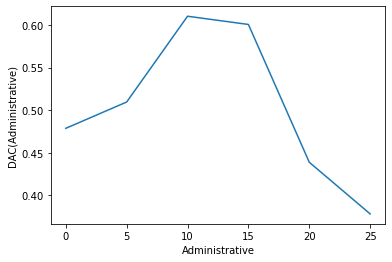

In [69]:
feature=features[0]
idx = np.argmax(features==features[0])
dac_1d,x_axis = get_1D_dac(rfc,X_train.to_numpy(),y_train,S,feat_intervals,feat_di,idx,feature,features)

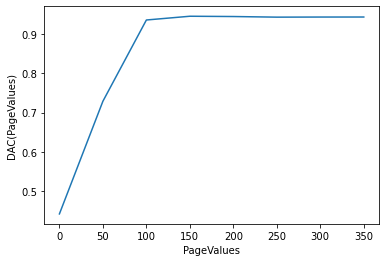

In [102]:
feature='PageValues'x
idx = np.argmax(features=='PageValues')
dac_1d,x_axis = get_1D_dac(rfc,X_train.to_numpy(),y_train,S,feat_intervals,feat_di,idx,feature,features)

### Feature Engineering with DAC

In [73]:
def get_importance_scores(model, score_type='mdi', X=None, Y=None):
    if score_type == 'mdi':
        return model.feature_importances_
    elif score_type == 'mda':
        return eli5.sklearn.PermutationImportance(model, random_state=42, n_iter=4).fit(X, Y).feature_importances_
    else:
        raise NotImplementedError(f'{score_type} not implemented')

In [75]:
feature_scores_mdi = get_importance_scores(rfc, score_type='mdi', X=X_test, Y=y_test)

In [76]:
feature_scores_mdi

array([4.52906526e-02, 3.50699512e-02, 1.34726966e-02, 1.24907811e-02,
       4.18275854e-02, 5.03555747e-02, 2.84410544e-02, 6.31149174e-02,
       4.11080519e-01, 1.92278955e-03, 2.32329493e-02, 1.62361378e-02,
       2.07890154e-02, 2.49163120e-02, 2.78038949e-03, 1.35299805e-02,
       1.24489401e-04, 5.16438523e-03, 1.90605622e-03, 1.30248599e-02,
       2.59793500e-02, 6.51514052e-02, 5.92419178e-03, 6.41002635e-03,
       2.63319904e-02, 3.57790742e-04, 2.57697804e-02, 1.93043680e-02])

In [77]:
feat_num = np.argsort(feature_scores_mdi)[-1]

In [78]:
features[feat_num]

'PageValues'

In [79]:
continuous_y = False

num_features = len(features)
feat_num = np.argsort(feature_scores_mdi)[-1]

S = np.zeros(num_features)
S[feat_num]= 1

In [81]:
## dac.interactions_forest does not exist
X_alt_train = dac(forest=rfc, input_space_x=X_train.to_numpy(), outcome_space_y=y_train,assignment=X_train.to_numpy(), S=S, continuous_y=continuous_y).reshape(-1, 1)

In [83]:
np.save("X_alt_train.npy",X_alt_train)

In [86]:
X_alt_test = dac(forest=rfc, input_space_x=X_train.to_numpy(), outcome_space_y=y_train, 
                                              assignment=X_test.to_numpy(), S=S, continuous_y=continuous_y).reshape(-1, 1)

In [87]:
np.save("X_alt_test.npy",X_alt_test)

### Add New Feature to Data

In [91]:
X_train2 = np.hstack((X_train.to_numpy(),X_alt_train))
X_test2 = np.hstack((X_test.to_numpy(),X_alt_test))

In [92]:
np.save("X_train2.npy",X_train2)
np.save("X_test2.npy",X_test2)

## Model with Feature Engineering

In [94]:
best_params = {'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto'}

# rfc = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=2, random_state=0)
rfc2 = RandomForestClassifier(**best_params)
rfc2.fit(X_train2, y_train)

In [120]:
get_performance(rfc2,X_test2,y_test)

               precision    recall  f1-score   support

0: No Revenue       0.93      0.93      0.93      3436
   1: Revenue       0.93      0.93      0.93      3436

     accuracy                           0.93      6872
    macro avg       0.93      0.93      0.93      6872
 weighted avg       0.93      0.93      0.93      6872

Confusion Matrix:
 [[3210  226]
 [ 236 3200]]
Accuracy:  0.9327706635622818
ROC-AUC:  0.9843582925295542


## Model with Feature Selection and Feature Engineering

In [106]:
## removed 28 index
to_keep = [8, 7, 4, 1, 10, 21, 24, 0, 26, 27, 2, 12, 11, 6, 20, 19, 13, 5, 3]

In [109]:
X_train_ss = X_train.iloc[:,to_keep]
X_test_ss = X_test.iloc[:,to_keep]

In [110]:
X_train3 = np.hstack((X_train_ss.to_numpy(),X_alt_train))
X_test3 = np.hstack((X_test_ss.to_numpy(),X_alt_test))

In [112]:
np.save("X_train3.npy",X_train3)
np.save("X_test3.npy",X_test3)

In [113]:
best_params = {'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto'}

# rfc = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=2, random_state=0)
rfc3 = RandomForestClassifier(**best_params)
rfc3.fit(X_train3, y_train)

In [121]:
get_performance(rfc3,X_test3,y_test)

               precision    recall  f1-score   support

0: No Revenue       0.93      0.93      0.93      3436
   1: Revenue       0.93      0.93      0.93      3436

     accuracy                           0.93      6872
    macro avg       0.93      0.93      0.93      6872
 weighted avg       0.93      0.93      0.93      6872

Confusion Matrix:
 [[3210  226]
 [ 235 3201]]
Accuracy:  0.9329161816065192
ROC-AUC:  0.9837318365020918
